In [39]:
import pandas as pd
import numpy as np

In [40]:
df = pd.read_csv('https://raw.githubusercontent.com/cmgospod/Kuala_Lumpur/master/dataset.csv')
assert df.shape == (53883, 8)

In [41]:
df.head()

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing
0,"KLCC, Kuala Lumpur","RM 1,250,000",2+1,3.0,2.0,Serviced Residence,"Built-up : 1,335 sq. ft.",Fully Furnished
1,"Damansara Heights, Kuala Lumpur","RM 6,800,000",6,7.0,NaN,Bungalow,Land area : 6900 sq. ft.,Partly Furnished
2,"Dutamas, Kuala Lumpur","RM 1,030,000",3,4.0,2.0,Condominium (Corner),"Built-up : 1,875 sq. ft.",Partly Furnished
3,"Cheras, Kuala Lumpur",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Bukit Jalil, Kuala Lumpur","RM 900,000",4+1,3.0,2.0,Condominium (Corner),"Built-up : 1,513 sq. ft.",Partly Furnished


In [42]:
df.isnull().sum()

Location             0
Price              248
Rooms             1706
Bathrooms         2013
Car Parks        17567
Property Type       25
Size              1063
Furnishing        6930
dtype: int64

In [43]:
df1 = df.dropna(axis=0, subset=['Price'])

In [44]:
df1.dtypes

Location          object
Price             object
Rooms             object
Bathrooms        float64
Car Parks        float64
Property Type     object
Size              object
Furnishing        object
dtype: object

In [45]:
# Split out the Size column into the two columns it out to be
sizeframe = df1.Size.str.split(pat=':', expand=True)
sizeframe.columns = ['land_type', 'square_footage']
df2 = pd.concat([df1, sizeframe], axis = 1)
df3 = df2.drop(['Size'], axis=1)

In [46]:
# This regex removes everything inside parens to cut down on unique values
df3['Property Type'] = df3['Property Type'].str.replace(r" \(.*\)","")

In [47]:
# Delete outliers in the 'Car Parks' column
df4 = df3.drop(df3[df3['Car Parks'] > 20].index)


In [48]:
assert df4.shape == (53626, 9)

In [49]:
# Same for 'Bathrooms'
df5 = df4.drop(df4[df4['Bathrooms'] > 10].index)


In [50]:
# Cleaning the rooms column and splitting out into two columns
# to support inputs like '2+1'
df4.Rooms = df4.Rooms.replace({'Studio': '0', '20 Above': '21'})
roomframe = df4.Rooms.str.split(pat='+', expand=True)
roomframe = roomframe.replace('', '0')
roomframe = roomframe.replace(to_replace=[None], value='0')
roomframe.columns = ['bedrooms', 'other_rooms']
df5 = pd.concat([df4, roomframe], axis = 1)
df6 = df5.drop(['Rooms'], axis=1)
df6.bedrooms = df6.bedrooms.astype(float)
df6.other_rooms = df6.other_rooms.astype(float)

In [51]:
# Cleaning the Price column
df6.Price = df6.Price.str.replace('RM ', '')
df6.Price = df6.Price.str.replace(',','')
df6.Price = df6.Price.astype(float)

In [52]:
# This deals with the 'square footage' column. First common mistakes are fixed,
# then the column is split in two to deal with areas expressed in an 'x by y' format.
# Finally, the dimensions are combined back into a single number. Some areas
# are still nonstandard (e.g those expressed as acres) but they are changed to nans.
df6.square_footage = df6.square_footage.str.replace(' sq. ft.', '')
df6.square_footage = df6.square_footage.str.replace(',','')
df6.square_footage = df6.square_footage.str.replace(' ','')
df6.square_footage = df6.square_footage.str.replace("'",'')
df6.square_footage = df6.square_footage.str.lower()
sqftframe = df6.square_footage.str.split(pat='x',n=1,expand=True)
sqftframe.iloc[:,0] = pd.to_numeric(sqftframe.iloc[:,0], errors ='coerce')
sqftframe.iloc[:,1] = pd.to_numeric(sqftframe.iloc[:,1], errors ='coerce')
sqftframe.columns = ['size0', 'size1']
df7 = pd.concat([df6, sqftframe], axis = 1)
df7['size0'] = df7['size0'].fillna(value=1)
df7['size1'] = df7['size1'].fillna(value=1)
df7['square_feet'] = df7['size0'] * df7['size1']
df8 = df7.drop(columns=['square_footage', 'size0', 'size1'])
df8.square_feet = df8.square_feet.where(df8.square_feet > 100, np.nan)

In [53]:
# The 'Location' column has far too many unique values, so we
# take the top 50 and change the rest to 'Other'
top50 = df8['Location'].value_counts()[:50].index
df8.loc[~df8['Location'].isin(top50), 'Location'] = 'Other'

In [54]:
# On to outliers! Here we finish cleaning the 'square feet' column.
df8 = df8[df8.square_feet < 10000]
df8 = df8[df8.square_feet > 800]

In [55]:
# Ditto for price. This model covers two orders of magnitude
df8 = df8[df8.Price > 100000]
df9 = df8[df8.Price < 10000000]
df10 = df8[df8.Price < 6000000]

In [56]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [57]:
target = 'Price'
features = df10.columns.drop(['Price'])
X_train, X_test, y_train, y_test = train_test_split(df10[features], df10[target])

In [58]:
# MAE a bit over a million. R squared is of course 0
baseline = DummyRegressor()
baseline.fit(X_train, y_train)
y_pred = baseline.predict(X_test)
print(mean_absolute_error(y_test, y_pred))

893406.6591109799


In [59]:
# Due to the skew of the price, using the median gets a slightly
# better baseline
baseline = DummyRegressor(strategy='median')
baseline.fit(X_train, y_train)
y_pred = baseline.predict(X_test)
print(mean_absolute_error(y_test, y_pred))

831857.3626049258


In [60]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.pipeline import make_pipeline

In [61]:
pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'),
                         ce.OrdinalEncoder(), 
                         RandomForestRegressor(n_estimators=1000, min_samples_leaf=2))

In [62]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=X_test.shape[0])

In [63]:
pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
print(pipeline.score(X_val, y_val))

0.9664291950782409
0.9017279622826307


In [64]:
y_pred = pipeline.predict(X_val)
print(mean_absolute_error(y_val, y_pred))

193305.23681748335


In [65]:
print(pipeline.score(X_test, y_test))
y_pred = pipeline.predict(X_test)
print(mean_absolute_error(y_test, y_pred))

0.8986273378275322
198622.7101122004


In [79]:
import plotly.express as px
fig = px.histogram(df8, x="Price", title='All Outliers Included')

fig.show()

In [74]:
fig = px.histogram(df9, x="Price", title='Price Distribution with Minimal Cleaning')
fig.show()

In [75]:
fig = px.histogram(df10, x="Price", title='Price Distribution with More Aggressive Cleaning')
fig.show()

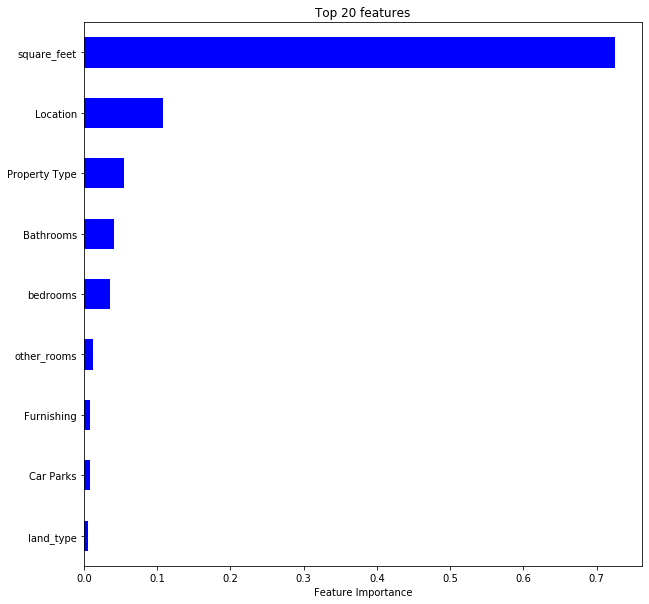

In [71]:
# Get feature importances
rf = pipeline.named_steps['randomforestregressor']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
plt.xlabel('Feature Importance')
importances.sort_values()[-n:].plot.barh(color='blue');

In [70]:
X_train.shape

(21682, 9)